In [1]:
from dotenv import load_dotenv
import os
import json
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import clickhouse_connect
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.cluster import KMeans
from datetime import datetime

In [2]:
# Load environment variables
load_dotenv('./dags/conf/.env', override=True)
# Load config
with open('./dags/conf/config.json', "r", encoding="utf-8") as f:
    CONFIG = json.load(f)

# Default database name
db = CONFIG['clickhouse']['dbs']['golden_db']

# TODO
CONFIG['clickhouse']['host'] = 'localhost'


In [3]:
# Create ClickHouse client
try:
    ch_client = clickhouse_connect.get_client(
        host=CONFIG['clickhouse']['host'],
        port=CONFIG['clickhouse']['port'],
        username=os.getenv('CLICKHOUSE_USER'),
        password=os.getenv('CLICKHOUSE_PASS')
    )
except Exception as e:
    print(f'Error creating ClickHouse client: {e}')

### 1. Определить зоны с наибольшим количеством посадок и высадок

In [4]:
# Number of top zones
top_zones_count = 10

try:
    # Top pickup zones
    sql = f'SELECT borough, `zone`, pickup_count FROM {db}.mv_zones_counts ORDER BY pickup_count DESC LIMIT {top_zones_count}'
    top_pickup_zones = ch_client.query_df(sql)

    # Top dropoff zones
    sql = f'SELECT borough, `zone`, dropoff_count FROM {db}.mv_zones_counts ORDER BY dropoff_count DESC LIMIT {top_zones_count}'
    top_dropoff_zones = ch_client.query_df(sql)

    print(f'Top-{top_zones_count} зон посадки:')
    print(top_pickup_zones.head(top_zones_count))
    print(f'\nTop-{top_zones_count} зон высадки:')
    print(top_dropoff_zones.head(top_zones_count))
except Exception as e:
    print(f'Error reading top taxi zones: {e}')

Top-10 зон посадки:
     borough                          zone  pickup_count
0  Manhattan             East Harlem North        691732
1  Manhattan         Upper East Side South        675401
2  Manhattan         Upper East Side North        656913
3  Manhattan             East Harlem South        650555
4  Manhattan                Central Harlem        649396
5  Manhattan                Midtown Center        629183
6  Manhattan  Penn Station/Madison Sq West        588667
7  Manhattan                      Union Sq        584118
8  Manhattan                  Midtown East        563793
9     Queens                       Astoria        556247

Top-10 зон высадки:
     borough                       zone  dropoff_count
0  Manhattan      Upper East Side North         800661
1  Manhattan      Upper East Side South         656810
2  Manhattan             Midtown Center         634462
3  Manhattan                Murray Hill         565750
4  Manhattan               Midtown East         525758
5 

In [5]:
# Show data in table format
top_pickup_zones.columns = ['Borough', 'Zone', 'Number of Pickups']
top_dropoff_zones.columns = ['Borough', 'Zone', 'Number of Dropoffs']

styled = (
    pd.concat(
        {
            "Top-10 Pickup Zones": top_pickup_zones,
            "Top-10 Dropoff Zones": top_dropoff_zones
        },
        axis=1
    )
    .style
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis="index")
)

display(styled)

### 2. Пиковые часы для поездок на такси

In [6]:
# Number of top hours
top_hours_count = 3

# Get hourly distribution of rides
sql = f'SELECT `hour`, rides_number FROM {db}.mv_rides_by_hour'
try:
    rides_by_hour = ch_client.query_df(sql)

    top_hours = rides_by_hour.sort_values('rides_number', ascending=False).head(top_hours_count)

    print(f'Top-{top_hours_count} часы по количеству поедок:')
    print(top_hours)
except Exception as e:
    print(f'Error reading peak hours: {e}')

Top-3 часы по количеству поедок:
    hour  rides_number
18    18       2808688
19    19       2729192
20    20       2415604


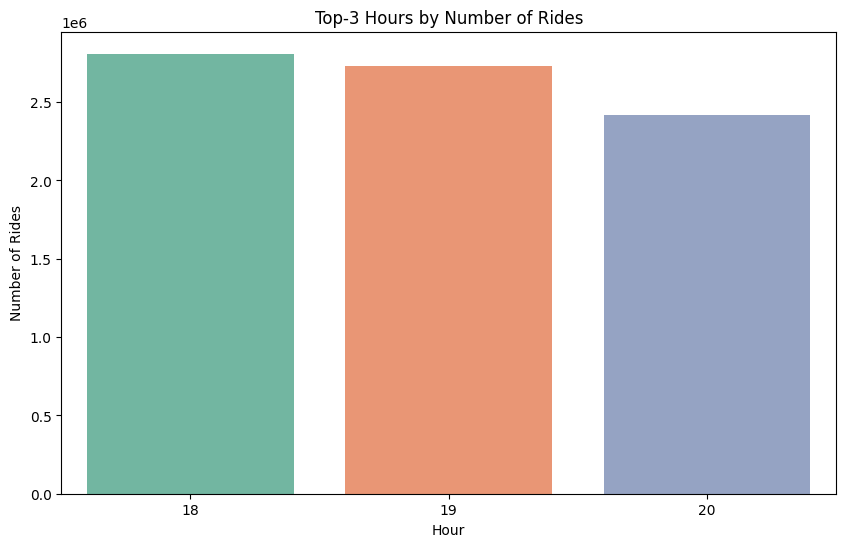

In [7]:
# Plot histogram of rides by hour
plt.figure(figsize=(10, 6))
sns.barplot(data=top_hours, x='hour', y='rides_number', palette='Set2', hue='hour', legend=False)
plt.title('Top-3 Hours by Number of Rides')
plt.xlabel('Hour') 
plt.ylabel('Number of Rides')
plt.xticks(range(0, top_hours_count))
plt.show()

### 3. Распределение поездок и мотивы пассажиров

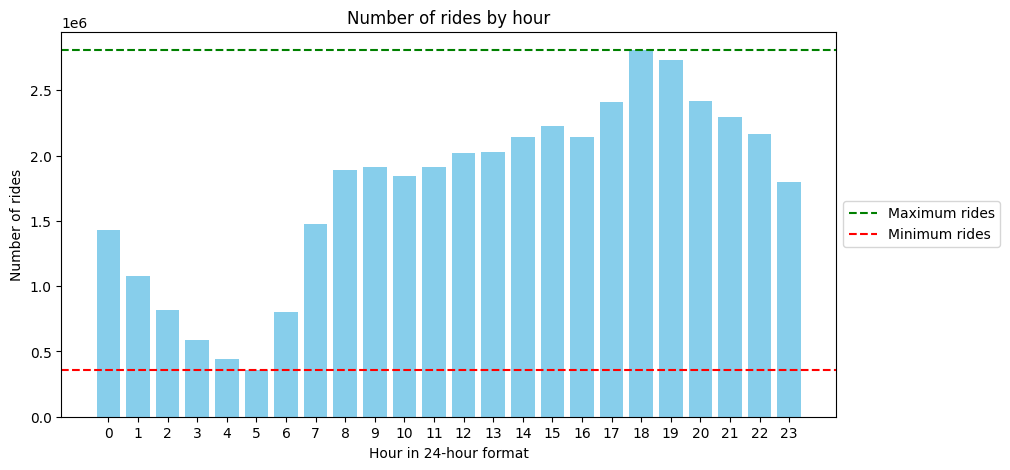

In [8]:
# Rides distribution by hour on plot
rides_by_hour

plt.figure(figsize=(10,5))
plt.bar(rides_by_hour['hour'], rides_by_hour['rides_number'], color='skyblue')

rides_min, rides_max = rides_by_hour['rides_number'].min(), rides_by_hour['rides_number'].max()
plt.axhline(rides_max, color='green', linestyle='--', label='Maximum rides')
plt.axhline(rides_min, color='red', linestyle='--', label='Minimum rides')

plt.xticks(range(0, 24))
plt.xlabel('Hour in 24-hour format')
plt.ylabel('Number of rides')
plt.title('Number of rides by hour')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

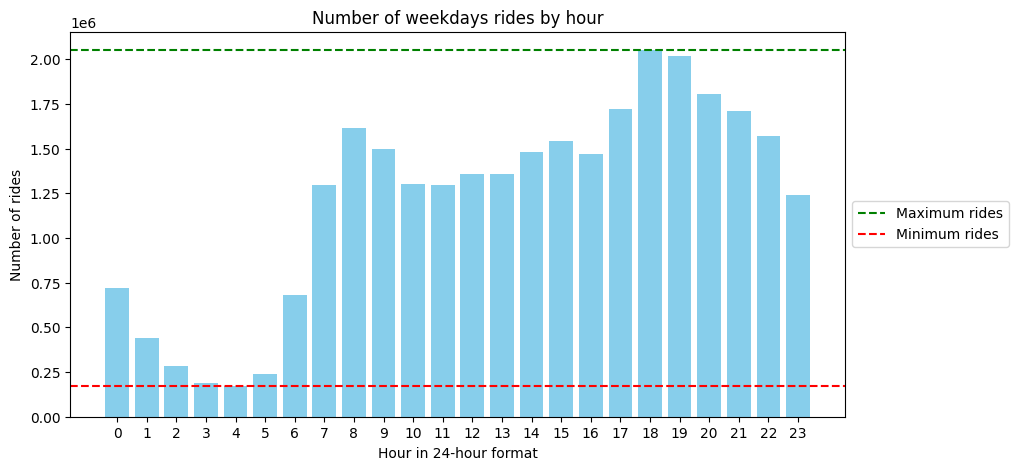

In [9]:
# Get hourly distribution of rides without airport rides, weekends and holidays
sql = f'SELECT `hour`, rides_number FROM {db}.mv_weekdays_by_hour'

try:
    weekdays_rides = ch_client.query_df(sql)

except Exception as e:
    print(f'Error reading weekdays distribution: {e}')

# Weekdays rides distribution by hour on plot
plt.figure(figsize=(10,5))
plt.bar(weekdays_rides['hour'], weekdays_rides['rides_number'], color='skyblue')

rides_min, rides_max = weekdays_rides['rides_number'].min(), weekdays_rides['rides_number'].max()
plt.axhline(rides_max, color='green', linestyle='--', label='Maximum rides')
plt.axhline(rides_min, color='red', linestyle='--', label='Minimum rides')

plt.xticks(range(0, 24))
plt.xlabel('Hour in 24-hour format')
plt.ylabel('Number of rides')
plt.title('Number of weekdays rides by hour')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

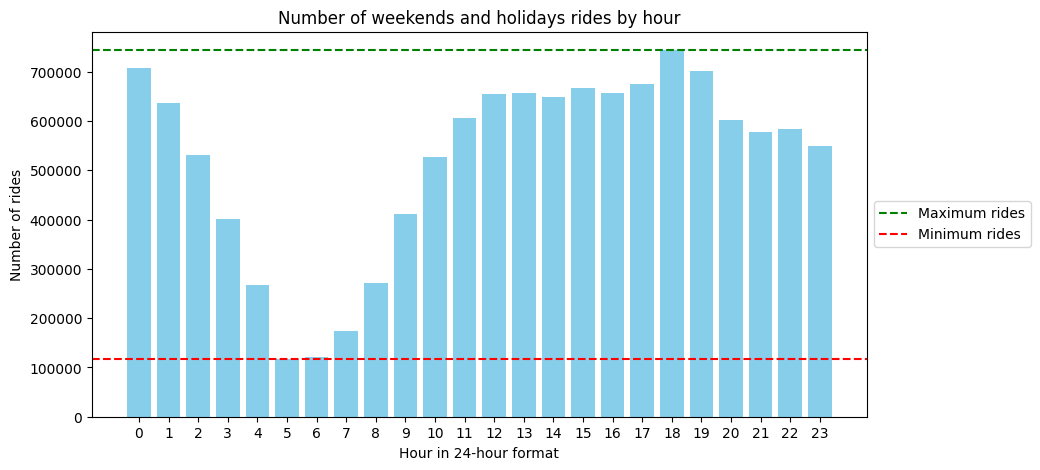

In [10]:
# Get hourly distribution of rides on weekends and holidays without airport rides
sql = f'SELECT `hour`, rides_number FROM {db}.mv_weekends_by_hour'

try:
    weekends_rides = ch_client.query_df(sql)

except Exception as e:
    print(f'Error reading weekends distribution: {e}')

# Weekdays rides distribution by hour on plot
plt.figure(figsize=(10,5))
plt.bar(weekends_rides['hour'], weekends_rides['rides_number'], color='skyblue')

rides_min, rides_max = weekends_rides['rides_number'].min(), weekends_rides['rides_number'].max()
plt.axhline(rides_max, color='green', linestyle='--', label='Maximum rides')
plt.axhline(rides_min, color='red', linestyle='--', label='Minimum rides')

plt.xticks(range(0, 24))
plt.xlabel('Hour in 24-hour format')
plt.ylabel('Number of rides')
plt.title('Number of weekends and holidays rides by hour')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 4. Пиковые часы для коротких и длинных поездок

In [11]:
# Calculate distance buckets boundaries with K-Means
# Get trip distances
sql = f"""
    SELECT trip_distance
        FROM {db}.fact_trip
"""

try:
    distance_df = ch_client.query_df(sql)

    print(distance_df['trip_distance'].describe())

    # Percentiles
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    print("\nDistance Percentiles:")
    for p in percentiles:
        value = distance_df['trip_distance'].quantile(p/100)
        print(f"  {p}th percentile: {value:.2f} miles")

except Exception as e:
    print(f"Error getting distances: {e}")
    raise

count    2.572949e+07
mean     1.736639e+00
std      1.145170e+00
min      0.000000e+00
25%      9.000000e-01
50%      1.410000e+00
75%      2.300000e+00
max      7.030000e+00
Name: trip_distance, dtype: float64

Distance Percentiles:
  10th percentile: 0.60 miles
  25th percentile: 0.90 miles
  50th percentile: 1.41 miles
  75th percentile: 2.30 miles
  90th percentile: 3.40 miles
  95th percentile: 4.10 miles
  99th percentile: 5.40 miles


In [12]:
# Reshape trip distances for KMeans
distances = distance_df['trip_distance'].values.reshape(-1, 1)

# Calculate distance buckets
# Use 4 tiers - Short, Normal, Long, Extra Long
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
distance_df['distance_cluster'] = kmeans.fit_predict(distances)


In [13]:
# Get cluster centers and sort them
centers = kmeans.cluster_centers_.flatten()
cluster_labels = np.argsort(centers)

label_mapping = {cluster_labels[0]: 'Short', 
                    cluster_labels[1]: 'Normal',
                    cluster_labels[2]: 'Long',
                    cluster_labels[3]: 'Extra long'}
distance_df['trip_category'] = distance_df['distance_cluster'].map(label_mapping)

# Calculate boundaries
short_max = distance_df[distance_df['trip_category'] == 'Short']['trip_distance'].max()
normal_max = distance_df[distance_df['trip_category'] == 'Normal']['trip_distance'].max()
long_max = distance_df[distance_df['trip_category'] == 'Long']['trip_distance'].max()

print(f"\nIdentified Trip Categories:")
print(f"  Short trips:  0 - {short_max:.2f} miles")
print(f"  Normal trips:  {short_max:.2f} - {normal_max:.2f} miles")
print(f"  Long trips:  {normal_max:.2f} - {long_max:.2f} miles")
print(f"  Extra long trips:   {long_max:.2f}+ miles")

# Compare distributions
dist = distance_df['trip_category'].value_counts(normalize=True).sort_index()
print(f"\nTrip Category Distribution")
print(dist)



Identified Trip Categories:
  Short trips:  0 - 1.24 miles
  Normal trips:  1.24 - 2.28 miles
  Long trips:  2.28 - 3.73 miles
  Extra long trips:   3.73+ miles

Trip Category Distribution
trip_category
Extra long    0.072056
Long          0.179903
Normal        0.323948
Short         0.424093
Name: proportion, dtype: float64


In [14]:
boundaries_df = pd.DataFrame({'Short': short_max, 'Normal': normal_max, 'Long': long_max}, index=[0])
styled = (boundaries_df
    .style
    .format("{:.2f}")
    .set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
        {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
        {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
        {"selector": "td", "props": [("background", "white"), ("color", "black")]},
    ])
    .hide(axis='index')
)

display(styled)


Short,Normal,Long
1.24,2.28,3.73


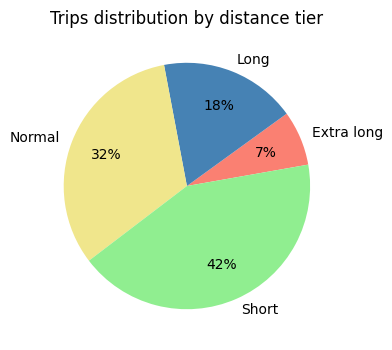

In [15]:
# Plot pie chart for trip categories
plt.figure(figsize=(8,4))
plt.pie(dist, startangle=10, colors=['salmon', 'steelblue', 'khaki', 'lightgreen'], labels=dist.index,
    autopct=lambda p: f"{p:.0f}%",
    pctdistance=0.7)
plt.title('Trips distribution by distance tier')
plt.show()

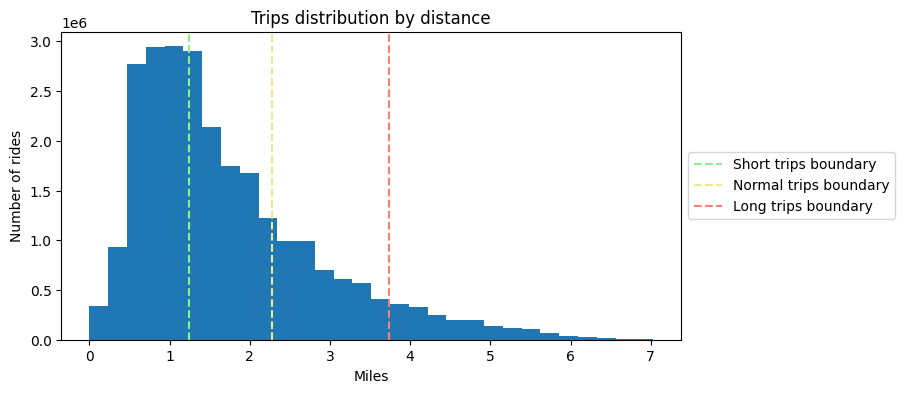

In [16]:
# Plot trips distance distribution on histogram
plt.figure(figsize=(8,4))
plt.hist(distance_df['trip_distance'], bins=30)
plt.xlabel('Miles')
plt.ylabel('Number of rides')
plt.title('Trips distribution by distance')
plt.axvline(short_max, color='lightgreen', linestyle='--', label='Short trips boundary')
plt.axvline(normal_max, color='khaki', linestyle='--', label='Normal trips boundary')
plt.axvline(long_max, color='salmon', linestyle='--', label='Long trips boundary')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [17]:
# Update table dim_distance with new values
try:
    sql = f"""
        INSERT INTO {db}.dim_distance(distance_bucket_id, distance_bucket_name, min_distance, max_distance, record_source)
        VALUES
    """
    # Short
    sql += f"(0, \'Short\', 0, {round(short_max, 2)}, \'K-means calculation on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\')"
    # Normal
    sql += f"(1, \'Normal\', {round(short_max, 2)}, {round(normal_max, 2)}, \'K-means calculation on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\')"
    # Long
    sql += f"(2, \'Long\', {round(normal_max, 2)}, {round(long_max, 2)}, \'K-means calculation on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\')"
    # Extra long
    sql += f"(3, \'Extra Long\', {round(long_max, 2)}, 999, \'K-means calculation on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\')"

    ch_client.command(sql)

except Exception as e:
    print(f"Error saving distance boundaries to db: {e}")

In [18]:
# Get distribution by trip distance
# Aggregate on Clickhouse side
sql_dist = f"""
    WITH dd AS (
        SELECT
            MAX(CASE WHEN LOWER(distance_bucket_name) = 'short' THEN max_distance END) AS short_max,
            MAX(CASE WHEN LOWER(distance_bucket_name) = 'normal' THEN max_distance END) AS normal_max,
            MAX(CASE WHEN LOWER(distance_bucket_name) = 'long' THEN max_distance END) AS long_max
        FROM (
            SELECT *
            FROM (
                SELECT distance_bucket_name,
                    max_distance,
                    row_number() OVER (PARTITION BY distance_bucket_name ORDER BY load_date DESC) AS rn
                FROM {db}.dim_distance
            ) t
            WHERE rn = 1
        ) t2
    )
    SELECT
        CASE 
            WHEN ft.trip_distance < dd.short_max THEN 'Short'
            WHEN ft.trip_distance < dd.normal_max THEN 'Normal'
            WHEN ft.trip_distance < dd.long_max THEN 'Long'
            ELSE 'Extra Long'
        END AS tier,
        dt.`hour`, count(ft.pickup_datetime_id) as dist_count
        FROM {db}.fact_trip AS ft
        CROSS JOIN dd
        INNER JOIN {db}.dim_datetime dt
            ON ft.pickup_datetime_id = dt.datetime_id
    GROUP BY tier, dt.`hour`
    ORDER BY tier, dt.`hour`
"""
try:
    rides_by_distance = ch_client.query_df(sql_dist)

except Exception as e:
    print(f'Error getting rides by distance: {e}')



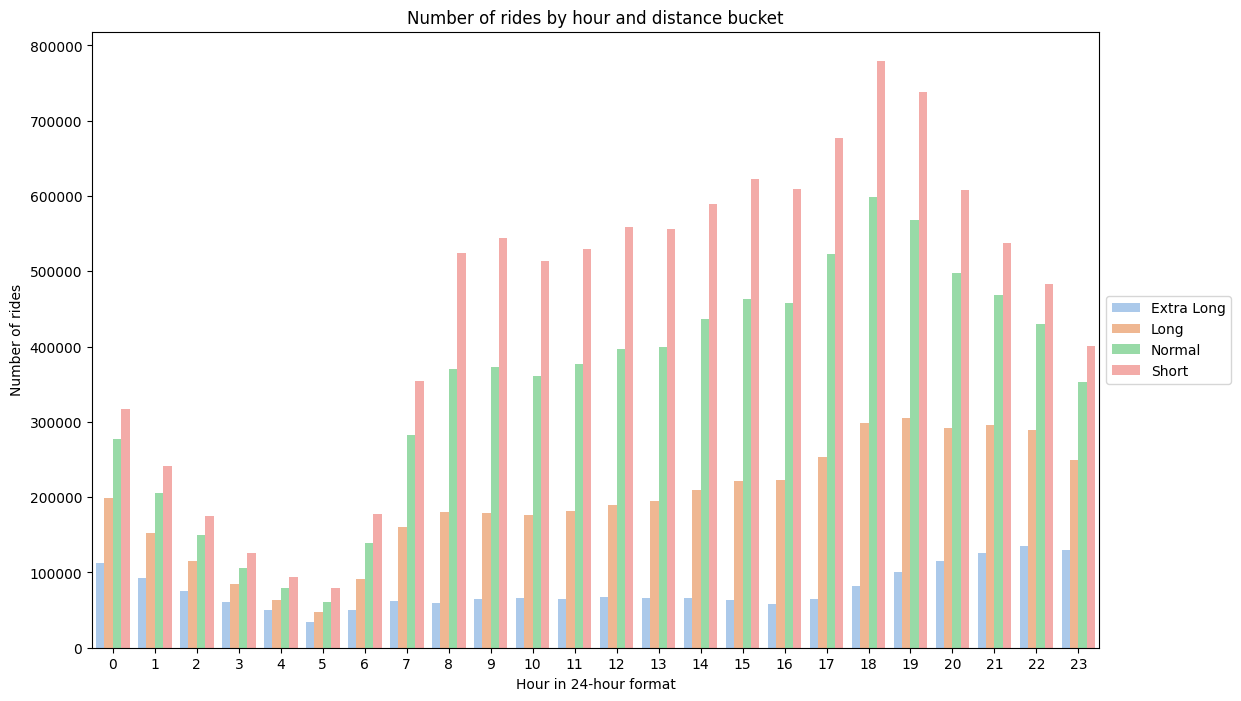

In [19]:
# Plot distribution of rides by distance and duration

# Distance plot
plt.figure(figsize=(13,8))
sns.barplot(data=rides_by_distance, x='hour', y='dist_count', hue='tier', legend=True, palette='pastel')
plt.xticks(range(0, 24))
plt.xlabel('Hour in 24-hour format')
plt.ylabel('Number of rides')
plt.title('Number of rides by hour and distance bucket')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### 5. Топ-3 зон посадки и высадки для разных типов поездок

In [21]:
# Number of top zones to show
top_zones_number = 3

# Get count of trips in each category by pickup zones
sql_pu = f"""
    WITH tmp as (
        SELECT PULocationID, sum(is_airport) AS "To/From airports", sum(is_peak_hour) AS "Peak hours",
            sum(is_weekend) AS "On weekends", sum(is_intra_zone) AS "Inside the same zone",
            sum(is_inter_borough) AS "Between boroughs"
        FROM {db}.fact_trip ft
            INNER JOIN {db}.mv_trip_categories tc
            ON ft.trip_hashkey = tc.trip_hashkey
        GROUP BY PULocationID)
    SELECT tmp.*, tz.`zone` FROM tmp
        INNER JOIN {db}.dim_taxi_zone tz
        ON tmp.PULocationID = tz.taxi_zone_id
"""

# Get count of trips in each category by dropoff zones
sql_do = f"""
    WITH tmp as (
        SELECT DOLocationID, sum(is_airport) AS "To/From airports", sum(is_peak_hour) AS "Peak hours",
            sum(is_weekend) AS "On weekends", sum(is_intra_zone) AS "Inside the same zone",
            sum(is_inter_borough) AS "Between boroughs"
        FROM {db}.fact_trip ft
            INNER JOIN {db}.mv_trip_categories tc
            ON ft.trip_hashkey = tc.trip_hashkey
        GROUP BY DOLocationID)
    SELECT tmp.*, tz.`zone` FROM tmp
        INNER JOIN {db}.dim_taxi_zone tz
        ON tmp.DOLocationID = tz.taxi_zone_id
"""

try:
    # Get all zones with counts by category
    top_pu = ch_client.query_df(sql_pu)
    top_pu['zone'] = top_pu['zone'].replace('nan', 'Unknown')

    top_do = ch_client.query_df(sql_do)
    top_do['zone'] = top_do['zone'].replace('nan', 'Unknown')

    # Get top zones for each category
    top_pu_zones = pd.DataFrame()
    for column in top_pu.columns[1:-1]:
        top_zones = top_pu.nlargest(top_zones_number, column)[['zone', column]].rename(columns={column: 'rides_count'})
        top_pu_zones = pd.concat([top_pu_zones, top_zones.assign(category=column)], ignore_index=True)

    top_do_zones = pd.DataFrame()
    for column in top_do.columns[1:-1]:
        top_zones = top_do.nlargest(top_zones_number, column)[['zone', column]].rename(columns={column: 'rides_count'})
        top_do_zones = pd.concat([top_do_zones, top_zones.assign(category=column)], ignore_index=True)

    # Make a copy of dataframe for display
    top_pu_zones_disp = top_pu_zones.copy()
    top_do_zones_disp = top_do_zones.copy()
    # Hide duplicate category names
    top_pu_zones_disp.loc[top_pu_zones_disp.duplicated(subset=['category']), 'category'] = ''
    top_do_zones_disp.loc[top_do_zones_disp.duplicated(subset=['category']), 'category'] = ''
    # Change column order
    top_pu_zones_disp = top_pu_zones_disp[['category', 'zone', 'rides_count']]
    top_pu_zones_disp.columns = ['Trip Category', 'Zone', 'Rides Count']
    top_do_zones_disp = top_do_zones_disp[['category', 'zone', 'rides_count']]
    top_do_zones_disp.columns = ['Trip Category', 'Zone', 'Rides Count']

    styled = (
        pd.concat(
            {
                f"Top-{top_zones_number} Pickup Zones": top_pu_zones_disp,
                f"Top-{top_zones_number} Dropoff Zones": top_do_zones_disp
            },
            axis=1
        )
        .style
        .set_table_styles([
            {"selector": "table", "props": [("border-collapse", "collapse"), ("width", "100%")]},
            {"selector": "th, td", "props": [("border", "1px solid #999"), ("padding", "6px")]},
            {"selector": "th", "props": [("background", "steelblue"), ("text-align", "center")]},
            {"selector": "td", "props": [("background", "white"), ("color", "black")]},
        ])
        .hide(axis="index")
    )

    display(styled)

except Exception as e:
    print(f'Error getting rides by category: {e}')


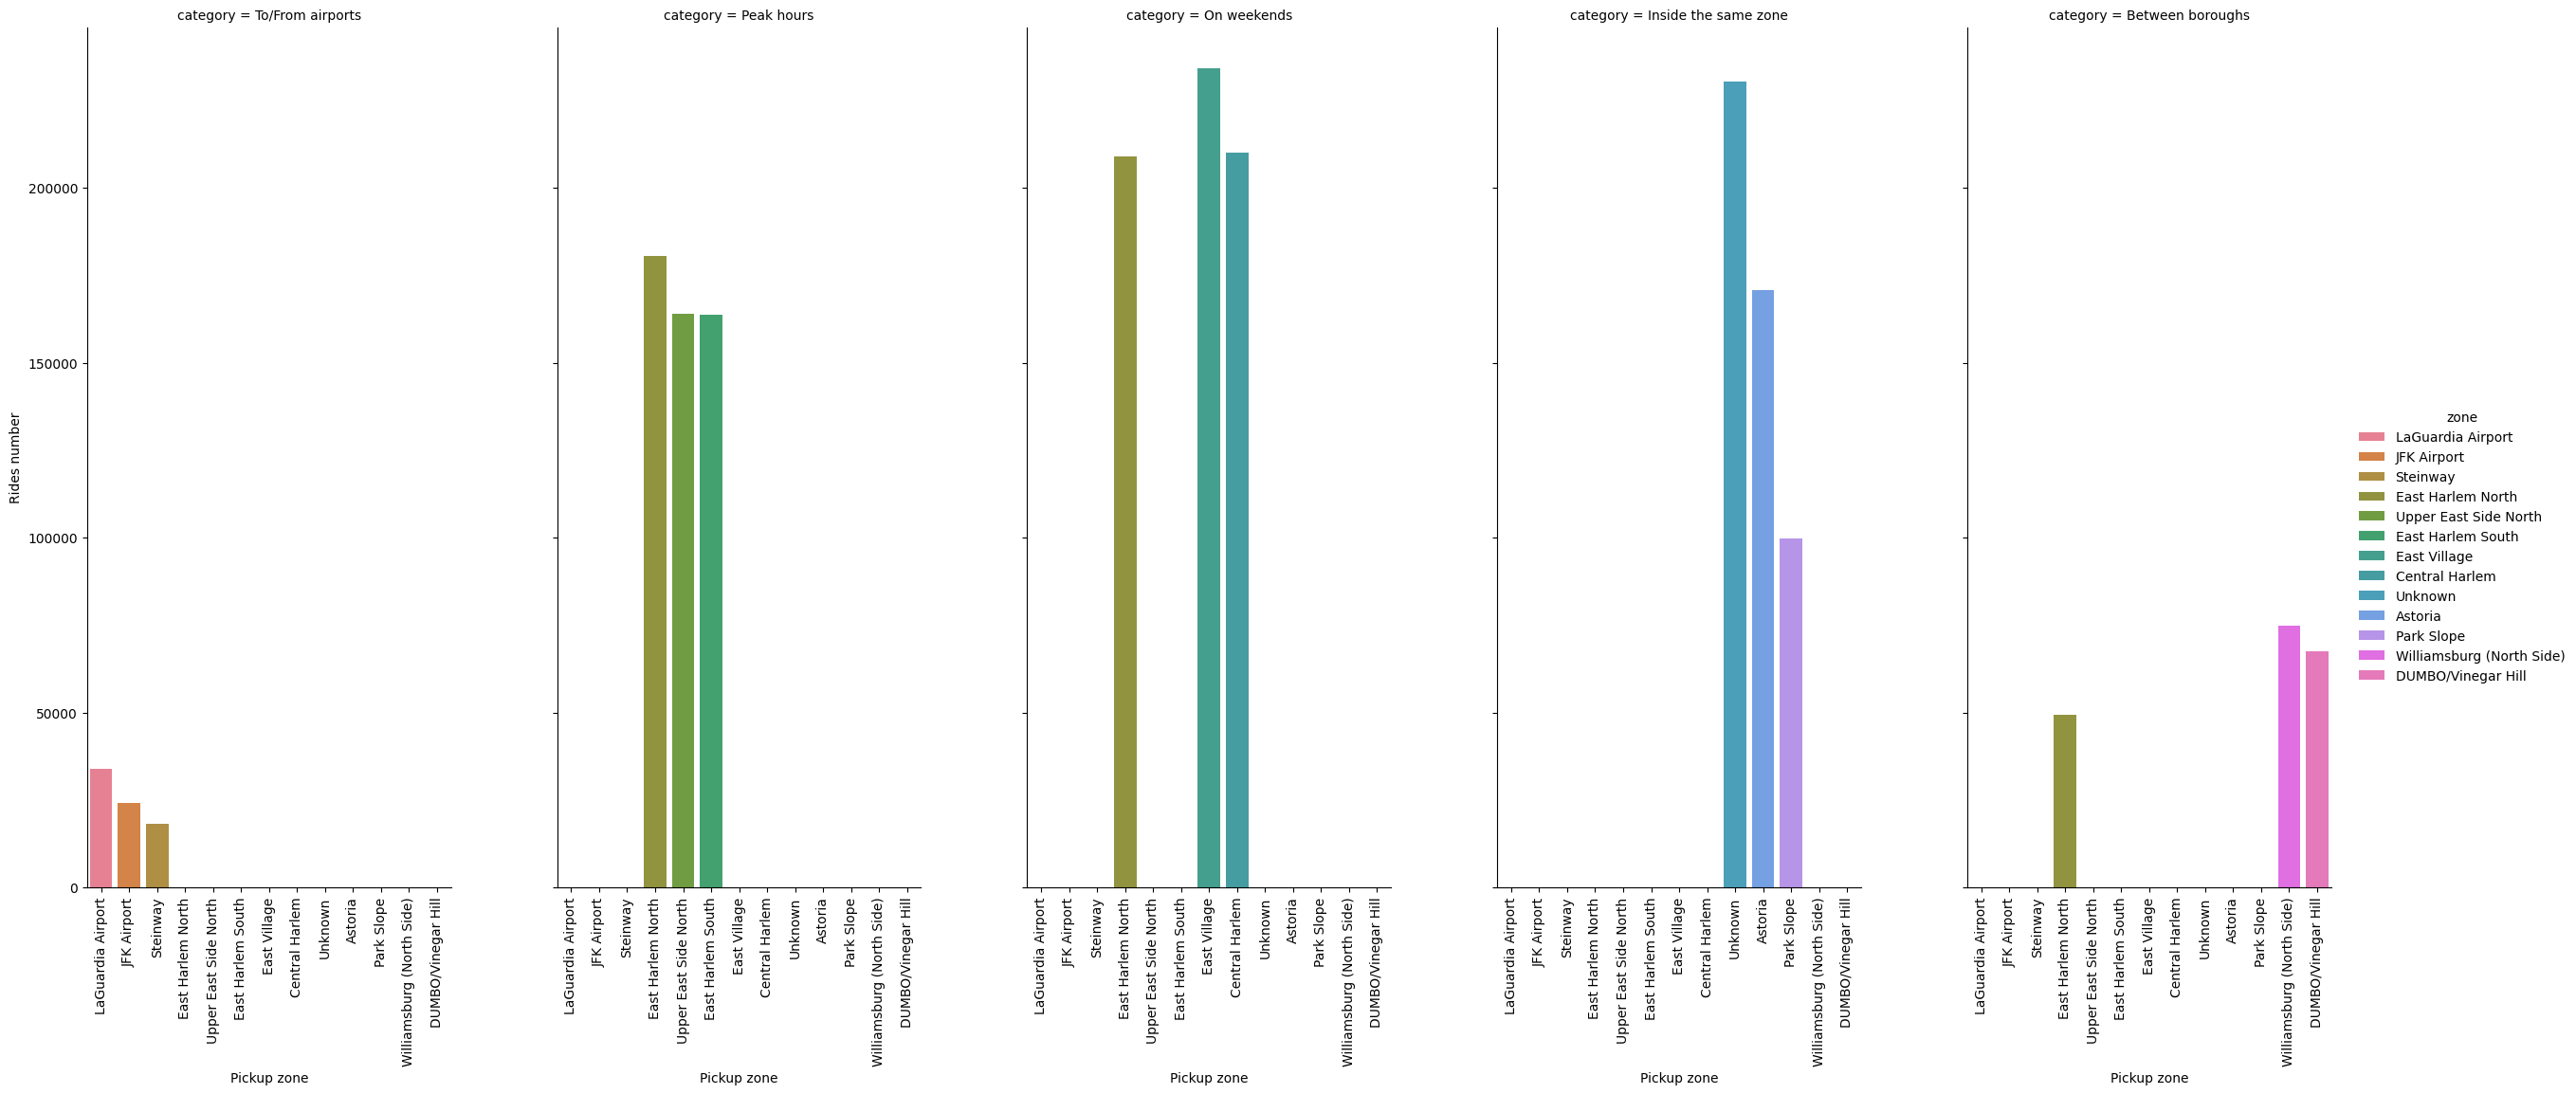

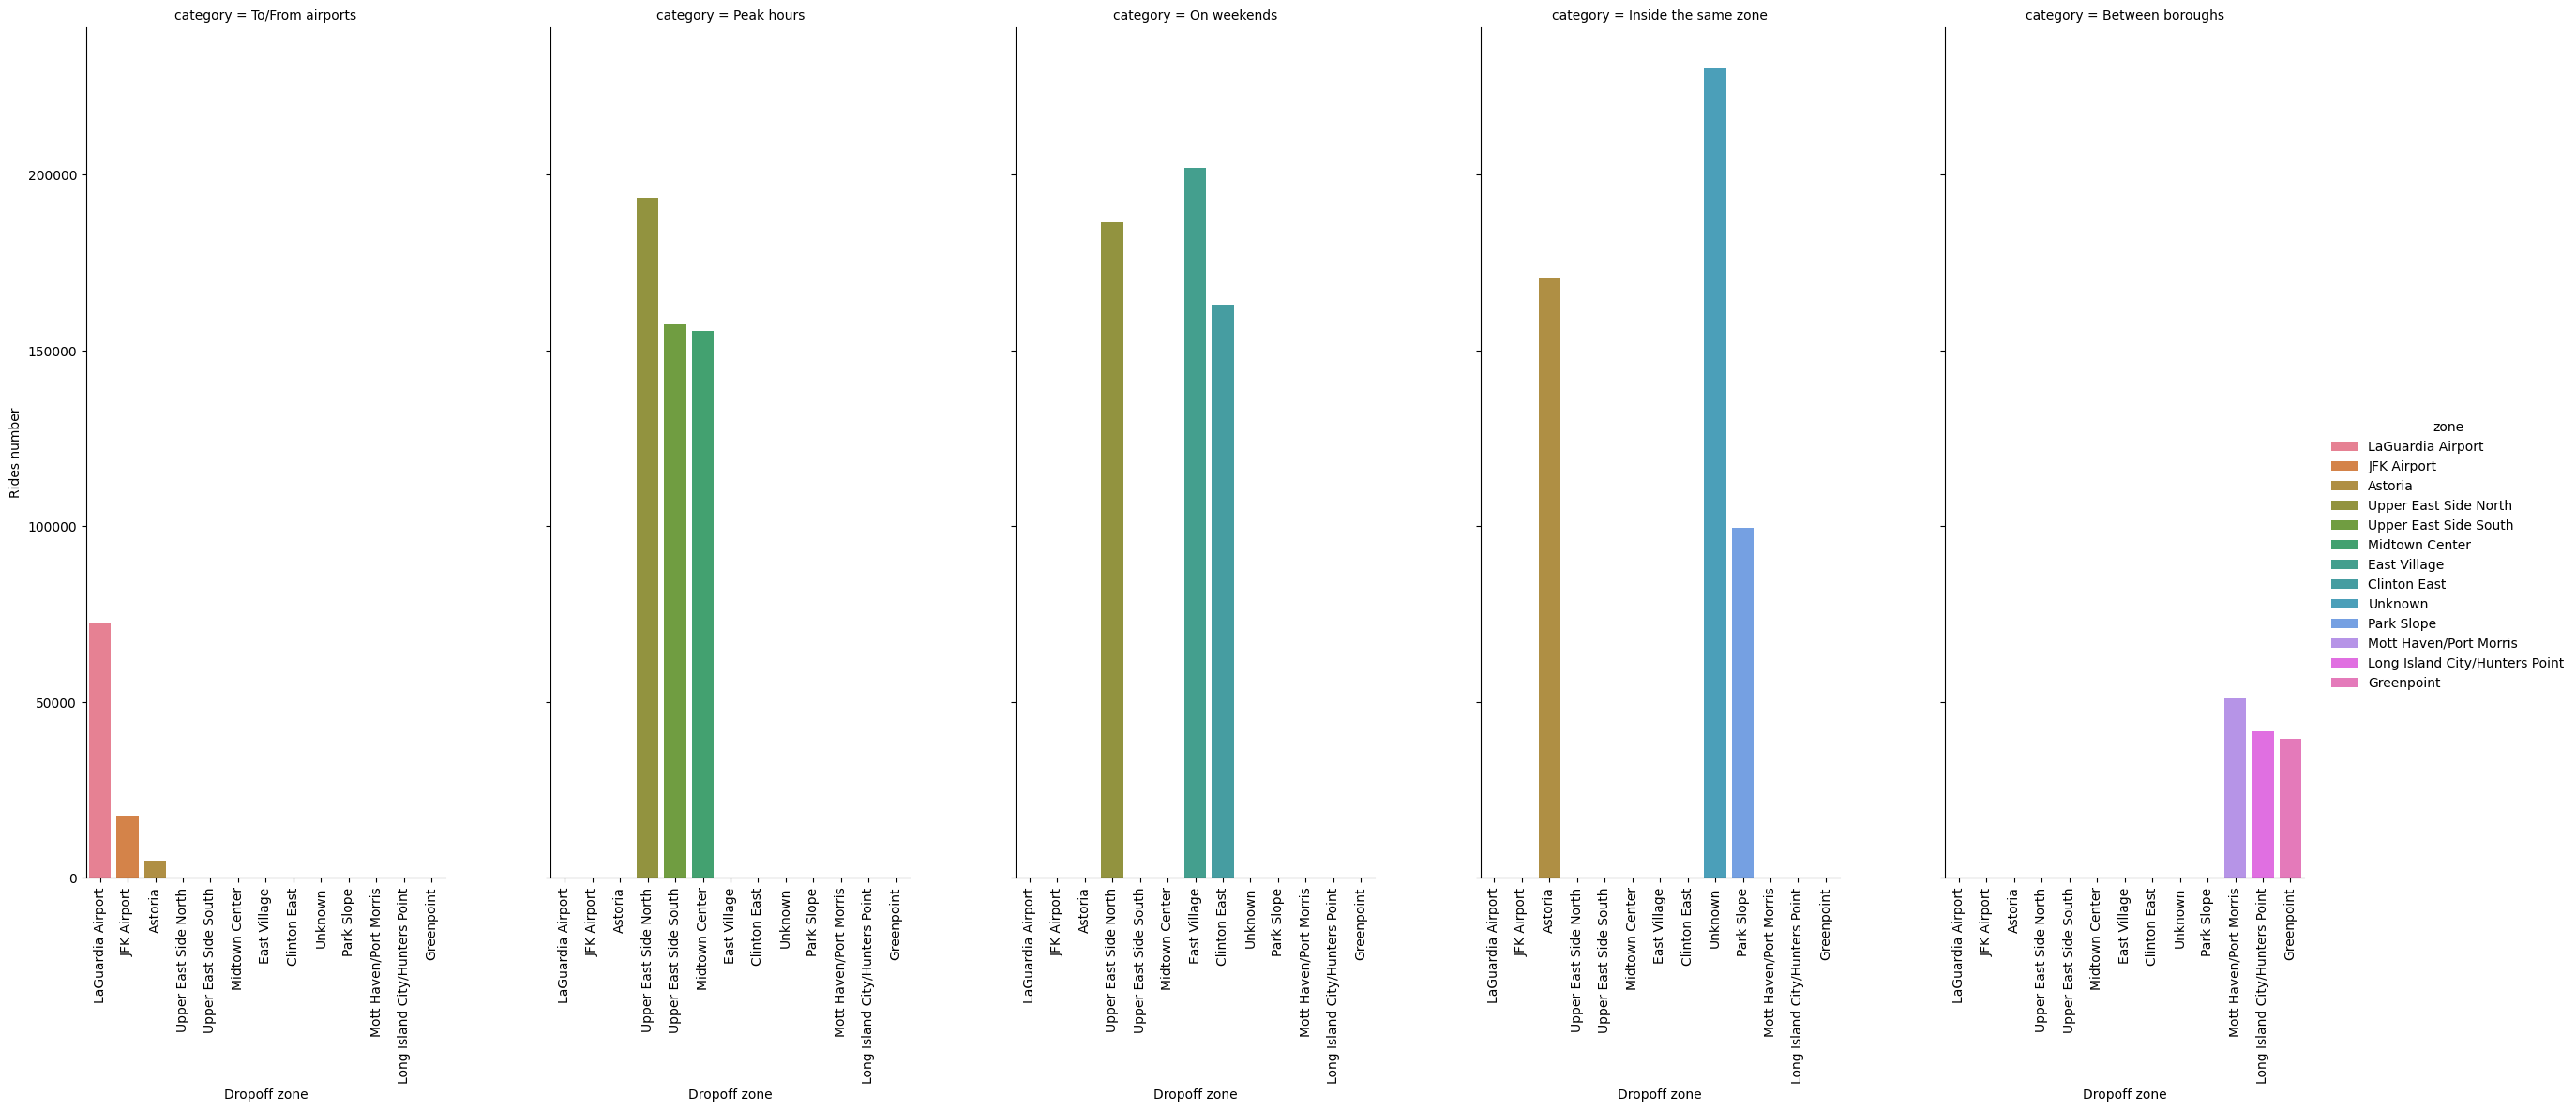

In [22]:
# Plot top pickup zones by category
g_pu = sns.FacetGrid(top_pu_zones, col='category', height=10, aspect=0.5, hue='zone', palette='husl', legend_out=True)
g_pu.map_dataframe(sns.barplot, x='zone', y='rides_count', dodge=False)
g_pu.add_legend()
g_pu.set_ylabels('Rides number')
g_pu.set_xlabels('Pickup zone')
g_pu.tick_params(axis='x', labelrotation=90)
plt.show()

# Plot top dropoff zones by category
g_do = sns.FacetGrid(top_do_zones, col='category', height=10, aspect=0.5, hue='zone', palette='husl', legend_out=True)
g_do.map_dataframe(sns.barplot, x='zone', y='rides_count', dodge=False)
g_do.add_legend()
g_do.set_ylabels('Rides number')
g_do.set_xlabels('Dropoff zone')
g_do.tick_params(axis='x', labelrotation=90)
plt.show()

### 6. Способы оплаты для различных типов поездок

In [23]:
# Get trips with categories and payment types
sql = f"""
    SELECT
        SUM(if(tc.is_airport, p.is_cash, 0)) AS "To/from airport_cash",
        SUM(if(tc.is_airport, p.is_digital, 0)) AS "To/from airport_digital",
        SUM(if(tc.is_peak_hour, p.is_cash, 0)) AS "Peak hours_cash",
        SUM(if(tc.is_peak_hour, p.is_digital, 0)) AS "Peak hours_digital",
        SUM(if(tc.is_weekend, p.is_cash, 0)) AS "On weekends_cash",
        SUM(if(tc.is_weekend, p.is_digital, 0)) AS "On weekends_digital",
        SUM(if(tc.is_intra_zone, p.is_cash, 0)) AS "In the same zone_cash",
        SUM(if(tc.is_intra_zone, p.is_digital, 0)) AS "In the same zone_digital",
        SUM(if(tc.is_inter_borough, p.is_cash, 0)) AS "Between boroughs_cash",
        SUM(if(tc.is_inter_borough, p.is_digital, 0)) AS "Between boroughs_digital"
    FROM {db}.mv_trip_categories tc
    INNER JOIN {db}.fact_trip ft
        ON tc.trip_hashkey = ft.trip_hashkey
    INNER JOIN {db}.dim_payment_type p
        ON ft.payment_type = p.payment_type_id
"""

try:
    payment_types = ch_client.query_df(sql)

    # Reshape dataframe for better display
    payment_types_disp = (payment_types.melt()
        .assign(
            category=lambda x: x['variable'].str.split('_').str[0],
            payment_type=lambda x: x['variable'].str.split('_').str[1]
        )
        .drop(columns=['variable'])
    )
    print(payment_types_disp)

except Exception as e:
    print(f'Error getting rides by payment type: {e}')


     value          category payment_type
0    60632   To/from airport         cash
1    70602   To/from airport      digital
2  2134724        Peak hours         cash
3  3604846        Peak hours      digital
4  3290733       On weekends         cash
5  4490702       On weekends      digital
6  1435528  In the same zone         cash
7  1279328  In the same zone      digital
8   561850  Between boroughs         cash
9   713808  Between boroughs      digital


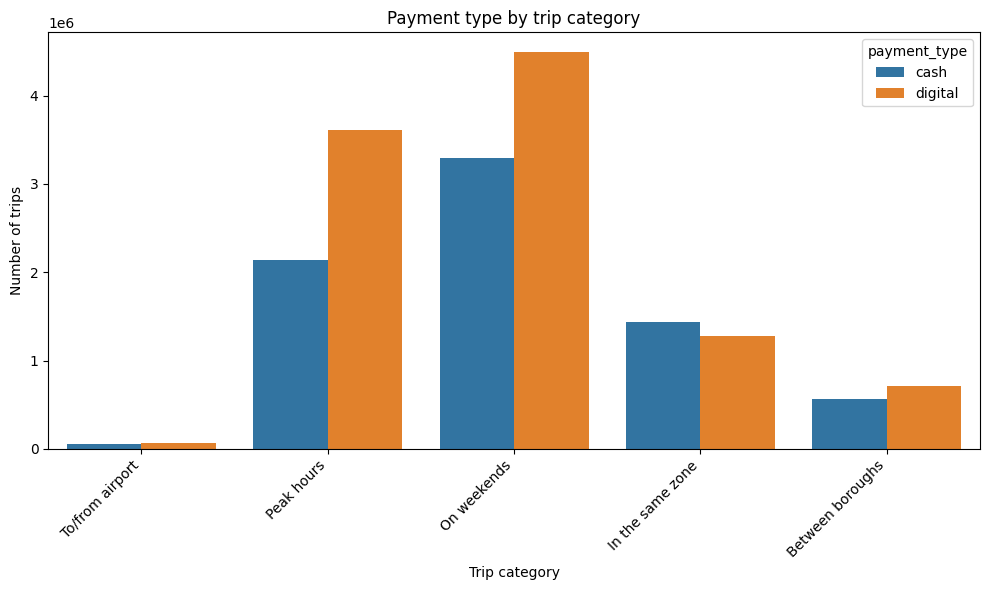

In [24]:
# Plot payment preferences

plt.figure(figsize=(10,6))
sns.barplot(
    data=payment_types_disp,
    x="category",
    y="value",
    hue="payment_type"
)

plt.ylabel('Number of trips')
plt.xlabel('Trip category')
plt.title('Payment type by trip category')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 7. Эволюция предпочтений в оплате со временем

In [25]:
sql = f"""
    SELECT CONCAT(dt.`year`, '/', dt.`month`) as year_month, SUM(pt.is_cash) as cash, SUM(pt.is_digital) as digital
        FROM {db}.fact_trip ft
        INNER JOIN {db}.dim_datetime dt
            ON ft.pickup_datetime_id = dt.datetime_id
        INNER JOIN {db}.dim_payment_type pt
            ON ft.payment_type = pt.payment_type_id
    GROUP BY dt.`month`, dt.`year`
    ORDER BY dt.`year`, dt.`month`
"""
# Get monthly distribution of payment types
try:
    payment_by_month = ch_client.query_df(sql)

except Exception as e:
    print(f'Error reading payment types by months: {e}')

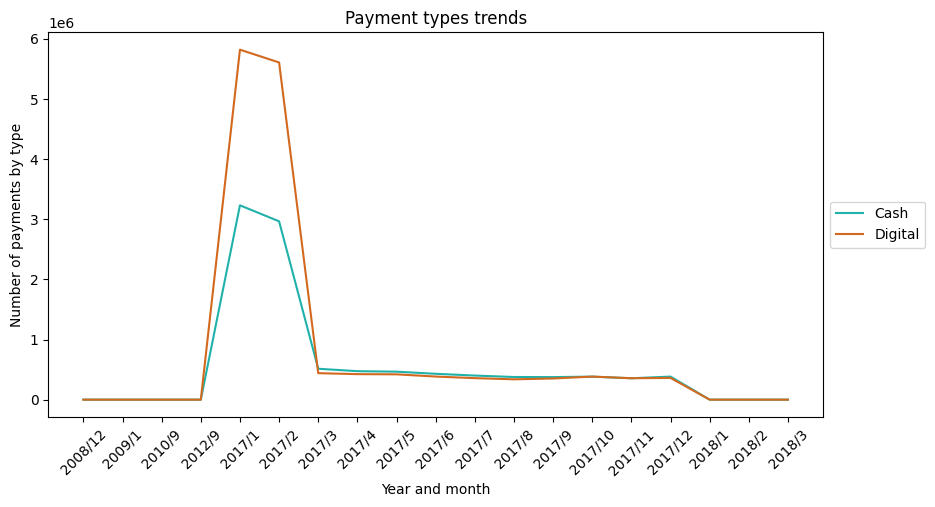

In [27]:
# Payment types distribution by month
plt.figure(figsize=(10,5))
plt.plot(payment_by_month['year_month'], payment_by_month['cash'], color='lightseagreen', label='Cash')
plt.plot(payment_by_month['year_month'], payment_by_month['digital'], color='chocolate', label='Digital')

plt.xlabel('Year and month')
plt.xticks(rotation=45)
plt.ylabel('Number of payments by type')
plt.title('Payment types trends')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 8. Возможность организации райдшеринга для коротких поездок в близлежащих зонах

In [28]:
# Get potential ride sharing trips
candidates_number = 50

sql = f"""
    SELECT v.vector, v.hour, v.minute, v.rides_count
    FROM {db}.mv_trip_vectors v
        WHERE v.vector IN
        (
            SELECT vector
                FROM {db}.mv_trip_vectors
                WHERE LOWER(vector) NOT LIKE '%unknown%'
            GROUP BY vector
            ORDER BY SUM(rides_count) DESC
            LIMIT {candidates_number}
        )
    ORDER BY v.rides_count DESC
"""
try:
    ride_sharing = ch_client.query_df(sql)

    # Round minutes down to nearest 15
    ride_sharing['minute_15'] = (ride_sharing['minute'] // 15) * 15

    # Create column for hour:minute format
    ride_sharing['time_key'] = ride_sharing['hour'].astype(str).str.zfill(2) \
        + ":" \
        + ride_sharing['minute_15'].astype(str).str.zfill(2)

except Exception as e:
    print(f'Error reading ridesharing candidates: {e}')

In [29]:
# Create pivot table for a heatmap plot
df_pivot = ride_sharing.pivot_table(
    index='vector',        
    columns='time_key',
    values='rides_count',
    aggfunc='sum',
    fill_value=0           # заменяем NaN на 0
)

# Показать первые 10 строк
print(df_pivot.head(10))

time_key                                            00:00  00:15  00:30  \
vector                                                                    
Brooklyn.Fort Greene->Brooklyn.Fort Greene            254    206    171   
Brooklyn.Park Slope->Brooklyn.Park Slope              567    506    407   
Brooklyn.Williamsburg (North Side)->Brooklyn.Gr...   1233   1072   1016   
Brooklyn.Williamsburg (North Side)->Brooklyn.Wi...    595    545    571   
Brooklyn.Williamsburg (North Side)->Brooklyn.Wi...    878    858    802   
Manhattan.Central Harlem North->Manhattan.Centr...    327    307    243   
Manhattan.Central Harlem North->Manhattan.Centr...    775    647    578   
Manhattan.Central Harlem->Manhattan.Central Harlem    632    616    552   
Manhattan.Central Harlem->Manhattan.Central Har...    785    739    698   
Manhattan.Central Harlem->Manhattan.East Harlem...    493    446    376   

time_key                                            00:45  01:00  01:15  \
vector                  

Median value for rides count: 441.0


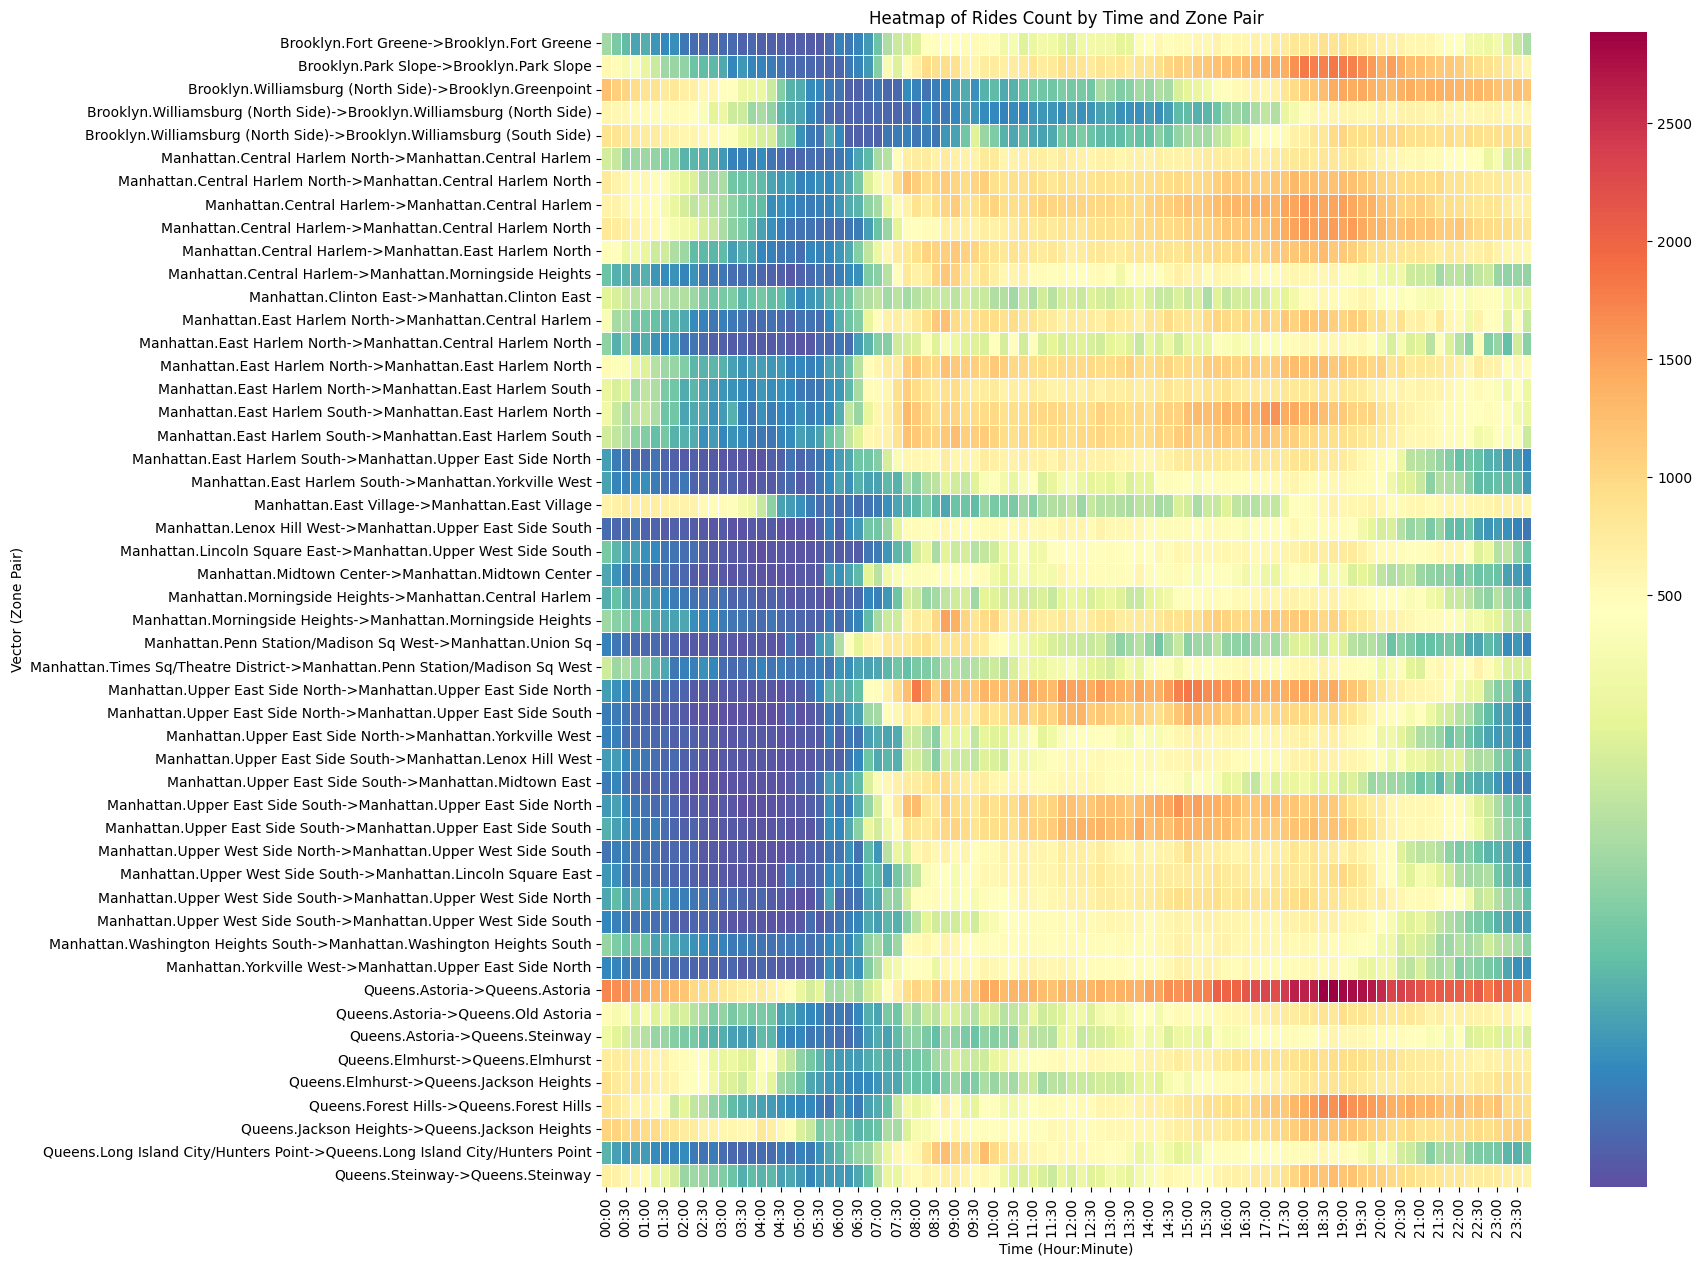

In [30]:
# Plot heatmap of potential ride sharing trips

# Set up normalization for better color distribution
# Calculate median value for normalization
median_val = np.median(df_pivot.values.flatten())
print('Median value for rides count:', median_val)
# Values <= median will be colored differently than values > median
norm = TwoSlopeNorm(vmin=df_pivot.values.min(), vcenter=median_val, vmax=df_pivot.values.max())

plt.figure(figsize=(15, 15))
sns.heatmap(df_pivot, cmap='Spectral_r', linecolor='white', linewidths=0.5, norm=norm)
plt.ylabel("Vector (Zone Pair)")
plt.xlabel("Time (Hour:Minute)")
plt.title("Heatmap of Rides Count by Time and Zone Pair")
plt.show()